In [21]:
%load_ext autoreload
%autoreload 2
from exojax.spec import make_numatrix,voigt
from exojax.spec import rtransfer as rt
from exojax.spec import planck
import numpy as np
import jax.numpy as jnp
from jax import random
from jax.lax import map, scan
from jax import vmap, jit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import hapi
hapi.db_begin('/home/kawahara/hapi/data/CO')

HAPI version: 1.1.2.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005
Using /home/kawahara/hapi/data/CO

05_HITEMP2019
                     Lines parsed: 752976


In [3]:
#hapi.describeTable('05_HITEMP2019')

In [3]:
import numpy as np
import astropy.units as u
#nm
llow=2290.0
lhigh=2450.0
#cm-1
wlow=1.e7/lhigh
whigh=1.e7/llow

wls = (np.arange(22900, 24500, 1.0) * u.Angstrom)[::-1]
nus = wls.to(1/u.cm, equivalencies=u.spectral()).value
wls = wls.value
nu_lo, nu_hi = nus.min().astype(np.int), nus.max().astype(np.int)

In [102]:
len(nus)

1600

In [4]:
n_air_all = hapi.getColumn('05_HITEMP2019', 'n_air')
gamma_air_all = hapi.getColumn('05_HITEMP2019', 'gamma_air')
gamma_self_all = hapi.getColumn('05_HITEMP2019', 'gamma_self')
nu_lines_all = hapi.getColumn('05_HITEMP2019', 'nu')
delta_air_all = hapi.getColumn('05_HITEMP2019', 'delta_air')
S_ij_all = hapi.getColumn('05_HITEMP2019', 'sw')

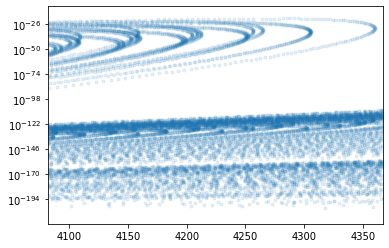

In [8]:
import matplotlib.pyplot as plt
plt.plot(nu_lines_all,S_ij_all,".",alpha=0.1)
plt.yscale("log")
plt.xlim(nus[0],nus[-1])
plt.show()

In [10]:
margin=100
crit=1.e-98
#mask=(S_ij_all>crit)
mask=(nu_lines_all>nus[0]-margin)*(nu_lines_all<nus[-1]+margin)*(S_ij_all>crit)
#mask=(nu_lines_all>nus[0]-margin)*(nu_lines_all<nus[-1]+margin)#*(S_ij_all>crit)

n_air=n_air_all[mask]
gamma_air=gamma_air_all[mask]
gamma_self=gamma_self_all[mask] 
nu_lines=nu_lines_all[mask] 
delta_air=delta_air_all[mask]
S_ij=S_ij_all[mask]

In [11]:
from jax import jit, vmap
import jax.numpy as jnp 
@jit
def lorentz_profile(nu, p, nu_ij, gamma, dp_ref, S_ij):
    '''Return the Lorentz line profile given vectors and parameters'''
    return S_ij/jnp.pi * gamma / ( gamma**2 + (nu - (nu_ij + dp_ref*p))**2)

In [12]:
@jit
def gamma_of_p_and_T(p, T, p_self, n_air, gamma_air_ref, gamma_self_ref):
    '''Compute the Lorentz HWHM with pressure and temp'''
    return (296.0/T)**n_air *(gamma_air_ref*(p-p_self) + gamma_self_ref*(p_self))

gammas = vmap(gamma_of_p_and_T, in_axes=(None, None, None, 0, 0, 0)\
                                )(10.0, 2000.0,0.001, n_air, gamma_air, gamma_self)

In [13]:
nus, wls = jnp.array(nus), jnp.array(wls)
nus.shape, gammas.shape

((1600,), (4277,))

In [17]:
line_profile = jit(vmap(lorentz_profile, in_axes=(None, None, 0, 0,0, 0)))(nus, np.array(1.0),nu_lines, gammas, delta_air, S_ij)
#line_profile.shape

In [18]:
net_abs_coeff = line_profile.sum(axis=0)

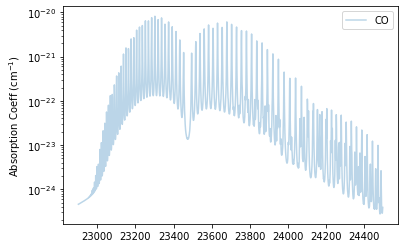

In [19]:
import matplotlib.pyplot as plt
plt.plot(wls, net_abs_coeff, alpha=0.3, label='CO')


#plt.plot(wls, coeff_air, label='$H_2O$ HAPI 6.0 s', alpha=0.3)
plt.yscale('log')
plt.ylabel('Absorption Coeff (cm$^{-1}$)')
plt.legend(loc='best')
plt.show()

In [22]:
# generating mock absorption data
np.random.seed(38)
N=len(nus)
nuarr=nus
Nmol=len(gammas)
hatnufix = nu_lines
Sfix=S_ij
nu0fix = 0.0
#f = lambda nu: lpf.MultiAbsVTc(nu-nu0fix,sDfix,gLfix,Afix,Sfix,hatnufix)

numatrix=make_numatrix(nuarr,hatnufix,nu0fix)
#cs=rt.cross(numatrix,sDfix,gLfix,Sfix)
np.shape(numatrix)

(4277, 1600)

In [23]:
wls[0],wls[-1]

(DeviceArray(24499., dtype=float32), DeviceArray(22900., dtype=float32))

In [24]:
sigmaD=0.3
vvoigt=jit(vmap(voigt,(0,None,0),0))

In [26]:
xsv = jnp.dot((vvoigt(numatrix,sigmaD,gammas)).T,S_ij)

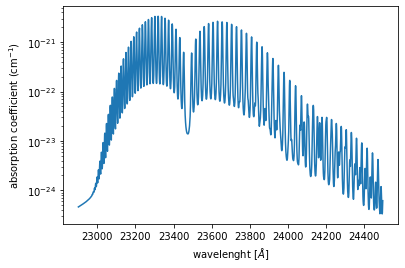

In [27]:
plt.plot(wls,xsv)
plt.yscale("log")
plt.ylabel('absorption coefficient (cm$^{-1}$)')
plt.xlabel('wavelenght [$\AA$]')
plt.show()